In [1]:

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import os
from sklearn.preprocessing import MinMaxScaler
from dynamics import *
import re
import math

#set latex font for plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
    

In [2]:
# Precompute embeddings for all readouts
def precompute_embeddings(datapoints_normalized):
    simulator = RydbergSimulator(
        nsites=nsites,
        atoms=atoms,
        readouts=readouts,
        omega=omega,
        t_start=t_start,
        t_end=t_end,
        t_step=t_step,
        t_rate=t_rate,
        alpha=alpha,
        V_matrix=V_matrix,
        id=0,
        use_wavelet=False
    )
    embeddings = simulator.apply_layer(datapoints_normalized)
    return readouts, embeddings

In [56]:
from sklearn.datasets import load_iris
data = load_iris()
#get x_train, y_train, x_test, y_test by random split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.5,shuffle=True, random_state=42)
    

Test MSE: 0.013333333333333334


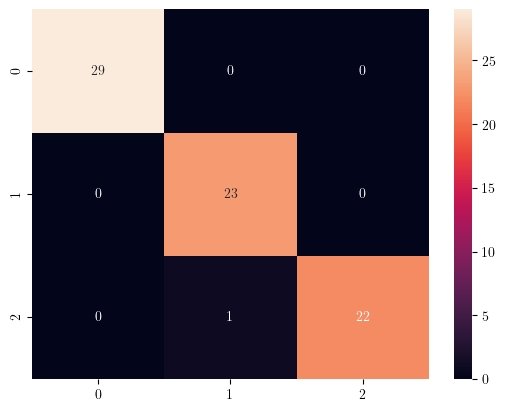

In [58]:
#use a simple random forest classifier
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.2, max_depth=1, random_state=0)
clf.fit(x_train, y_train)
#accuracy
y_pred = clf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print('Test MSE: {}'.format(mse))
#show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()
    

Plot saved as lattice_plot.pdf


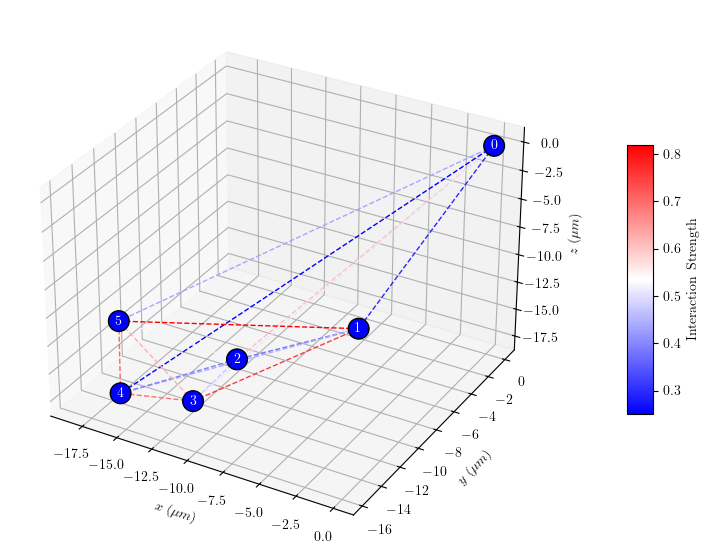

In [59]:
nsites =6
d = 10 # 10 micron spacing
atoms = np.linspace(0, (nsites - 1) * d, nsites)  # Put atoms in a chain with 10 micron spacing

# Hyperparameters for testing
omega = 2 * np.pi
t_start = 0.0
t_end = 3.0
t_step = 0.2
t_rate = 1.0
alpha = np.random.rand(nsites)  # Random site modulation factors between 0 and 1
V_matrix = np.random.rand(nsites, nsites)
V_matrix = (V_matrix + V_matrix.T) / 2  # Make the interaction matrix symmetric
np.fill_diagonal(V_matrix, 0.25)  # Set diagonal elements to 0.1
#use min-max normalization

# Call the function
plot_3d_lattice(nsites, d, atoms, alpha, V_matrix, save_as_pdf=True, filename="lattice_plot.pdf")

In [60]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_datapoints_normalized = scaler.fit_transform(x_train)
test_datapoints_normalized = scaler.transform(x_test)
custom_readouts = ["IIIZII","ZIIIII","IZIIII","XXXIII","IIIXXX","IIIIIX"]

#readouts = generate_readouts(nsites, custom_readouts)
readouts = generate_readouts(nsites)  #default readouts

readouts, train_embeddings = precompute_embeddings(train_datapoints_normalized)
readouts, test_embeddings = precompute_embeddings(test_datapoints_normalized)
train_embeddings=train_embeddings/(2**nsites) #normalize embeddings
test_embeddings=test_embeddings/(2**nsites) #normalize embeddings

100%|██████████| 75/75 [01:26<00:00,  1.15s/it]


MSE: 0.05333333333333334


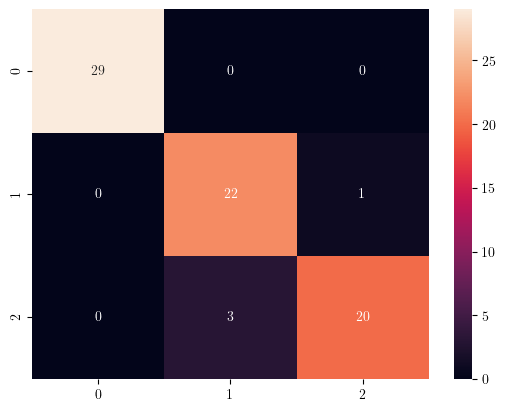

In [ ]:
#check the mse of the embeddings
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.2, max_depth=1, random_state=0)
clf.fit(train_embeddings, y_train)
#accuracy   
y_pred = clf.predict(test_embeddings)
mse = mean_squared_error(y_test, y_pred)
print('MSE: {}'.format(mse))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

In [72]:
t_steps = np.arange(t_start+t_step, t_end+t_step, t_step)
#reshape the embeddings to be in the shape of (n_samples, len(t_steps), :))
embd_per_t = train_embeddings.reshape(train_embeddings.shape[0], len(t_steps), -1)

The original value of the sample is:  [5.4 3.  4.5 1.5]


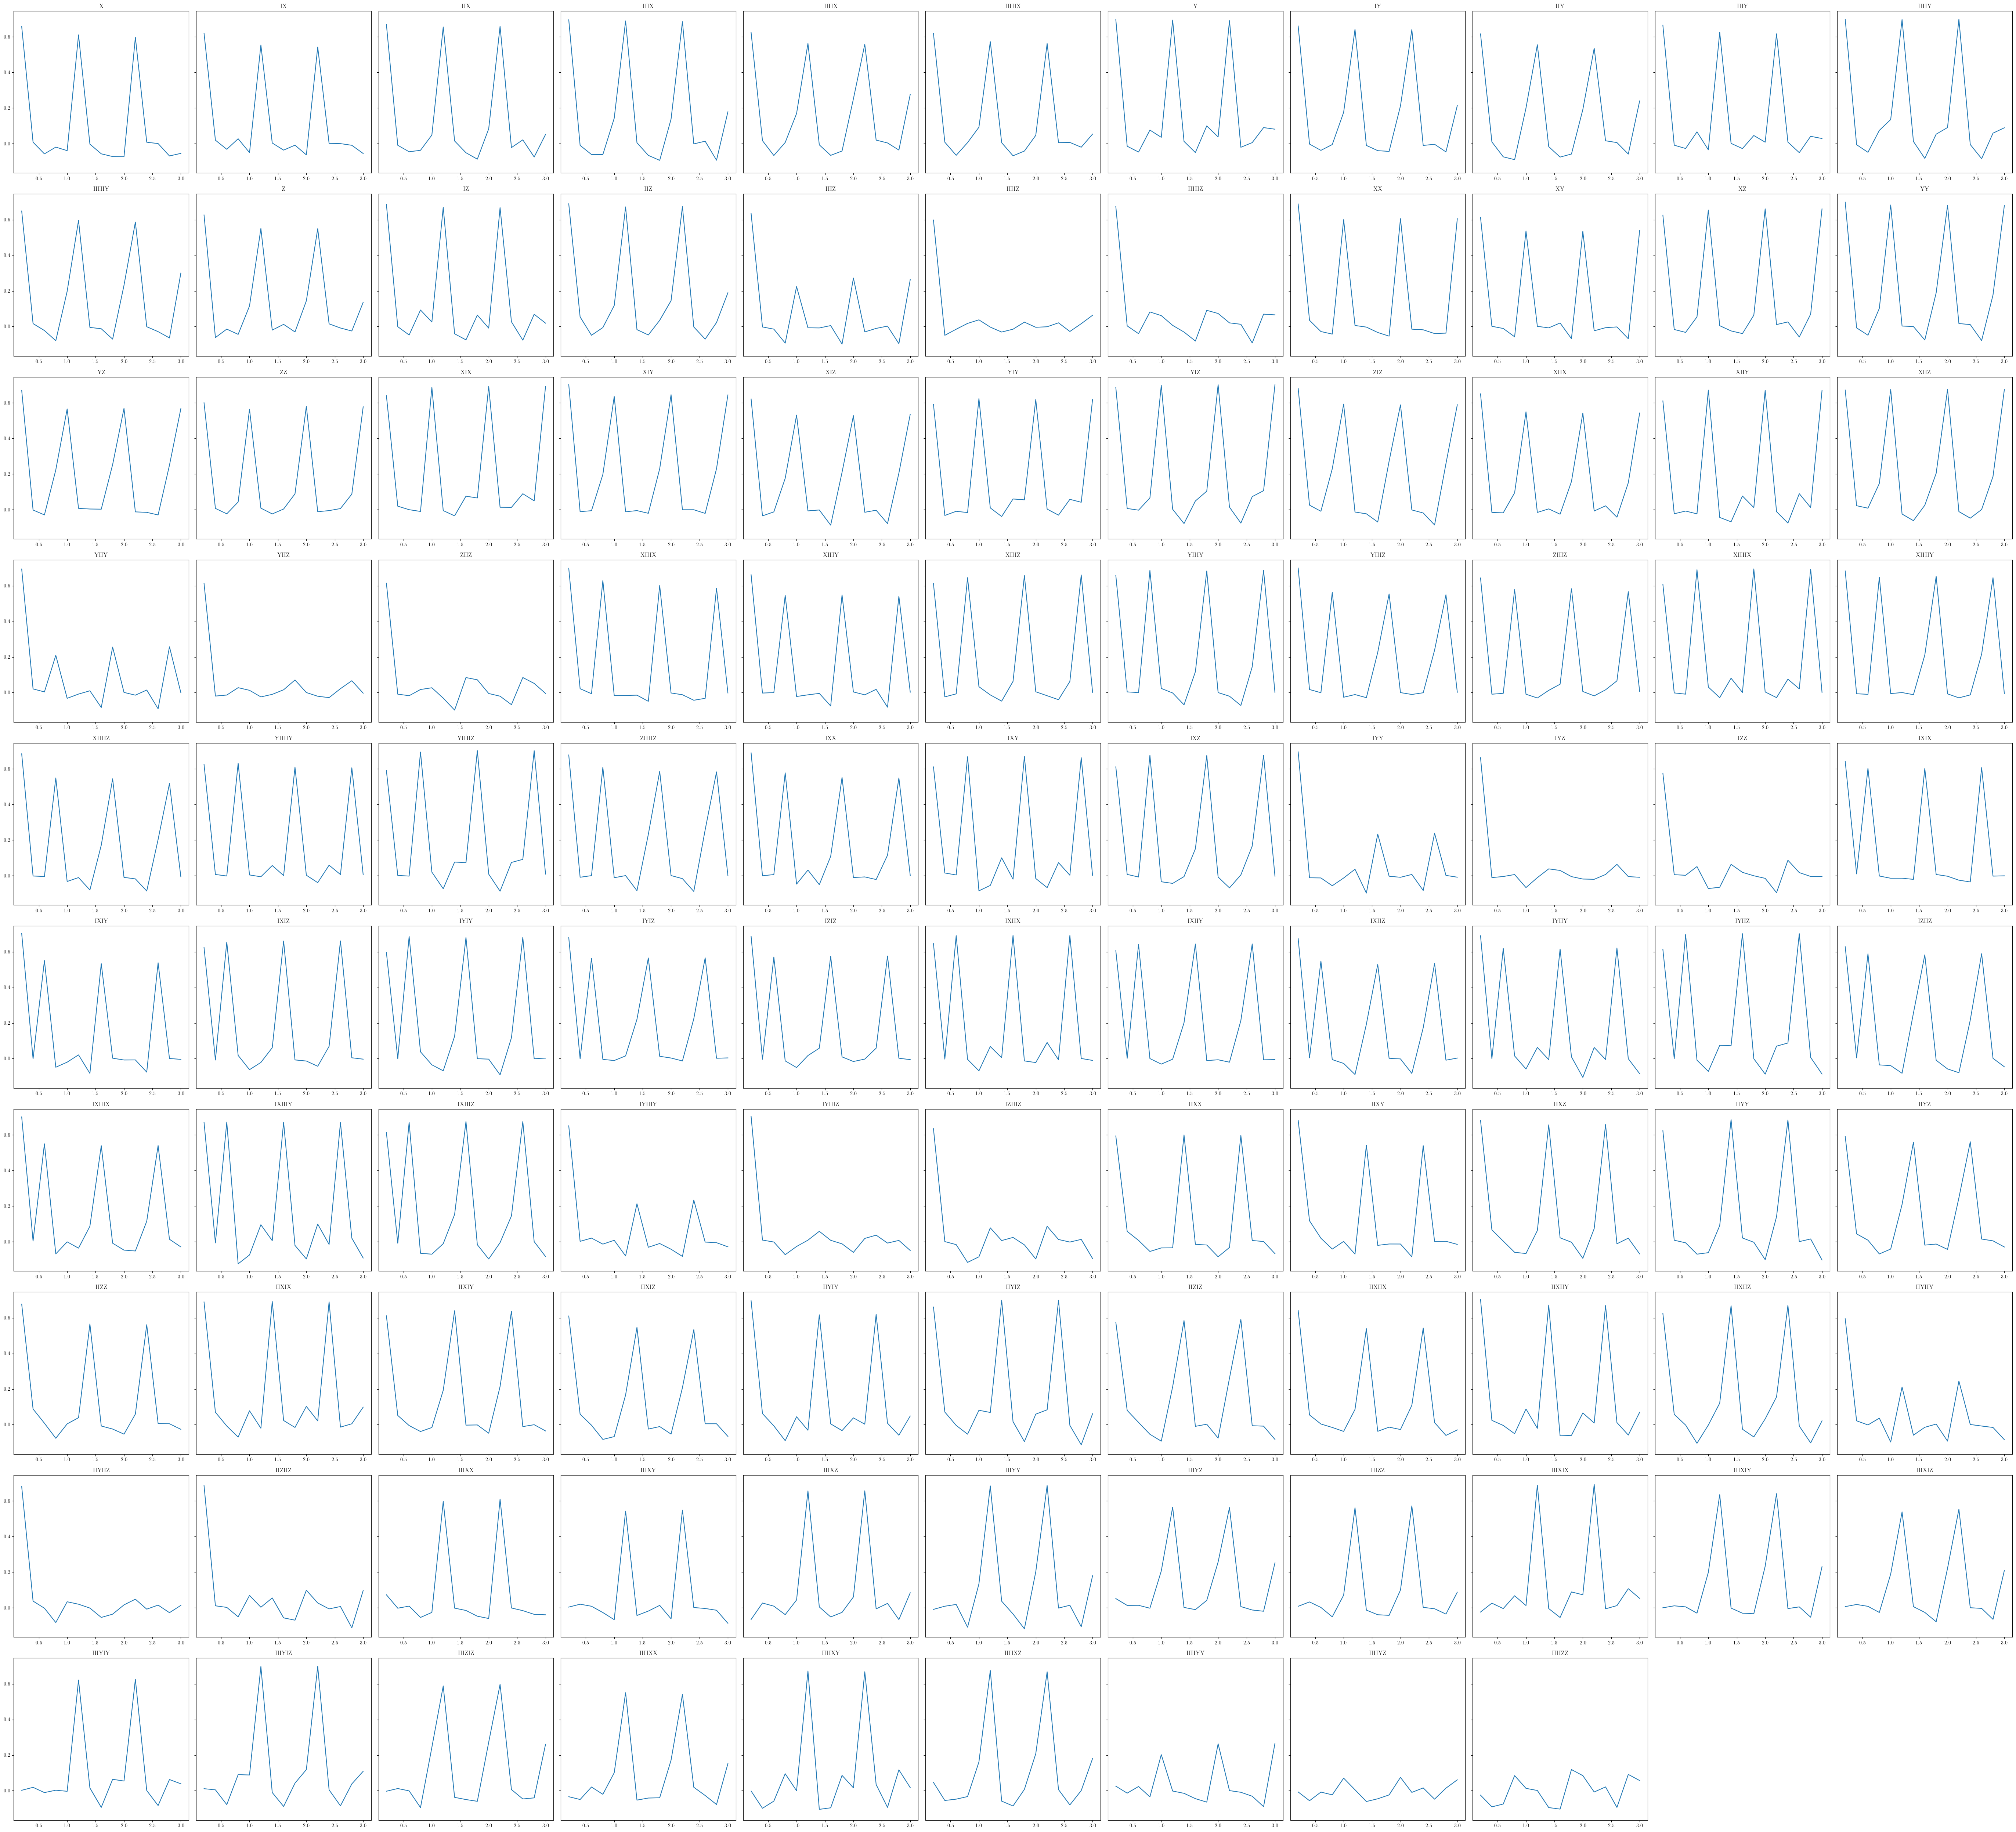

In [74]:
#visualize the expectaion values of all the readouts one by one
smple_idx = 0
print("The original value of the sample is: ", x_train[smple_idx])

# Define the number of rows and columns
num_readouts = len(readouts)
rows = 10  # Example: Number of rows
cols = math.ceil(num_readouts / rows)  # Calculate the required number of columns

# Create subplots with a grid layout
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), sharey=True)

# Flatten the axs array for easier indexing if it's multidimensional if more than one row

if num_readouts > 1: 
    axs = axs.flatten()

    for i, readout in enumerate(readouts):
        axs[i].plot(t_steps, embd_per_t[smple_idx, :, i])
        title = re.search(r"[IXYZ]+", readout.to_string()).group()
        axs[i].set_title(title)

    # Hide any unused subplots
    for j in range(len(readouts), len(axs)):
        axs[j].axis('off')
else:
    axs.plot(t_steps, embd_per_t[smple_idx, :, 0])
    title = re.search(r"[IXYZ]+", readouts[0].to_string()).group()
    axs.set_title(title)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()